In [26]:
import pathlib

import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import data
import utils
import losses

In [2]:
met = data.MET_Data("../data/raw/MET_full_data.npz")

In [132]:
experiment_path = pathlib.Path("../data/test/met_var")
exp_dict = utils.load_jit_folds(experiment_path, get_checkpoints = True)

In [80]:
specimen_ids = met.query(formats = [("logcpm",)], platforms = ["patchseq"])["specimen_id"]
loss_config = {"formats": {"T": ["logcpm"]}, "transform": {}, "device": "cpu"}
loss = losses.FeatureR2(loss_config, met, specimen_ids)

In [133]:
checkpoint_outputs = {}
for fold in list(exp_dict["folds"].values()):
    test_data = met.query(fold["test_ids"], formats = [("logcpm",)], platforms = ["patchseq"])["logcpm"]
    for (epoch, model) in fold["checkpoints"].items():
        (mean, transf) = model["T"]["enc"]({"logcpm": torch.from_numpy(test_data).float()})
        sample = model.z_sample(mean, transf)
        recon = model["T"]["dec"](sample)["logcpm"]
        checkpoint_outputs.setdefault(epoch, []).append((test_data, mean.detach(), transf.detach(), sample.detach(), recon.detach()))

In [134]:
check_losses = {epoch: np.mean([loss(torch.from_numpy(test_data), recon, "logcpm").numpy() for (test_data, _, _, _, recon) in outputs]) 
                     for (epoch, outputs) in checkpoint_outputs.items()}

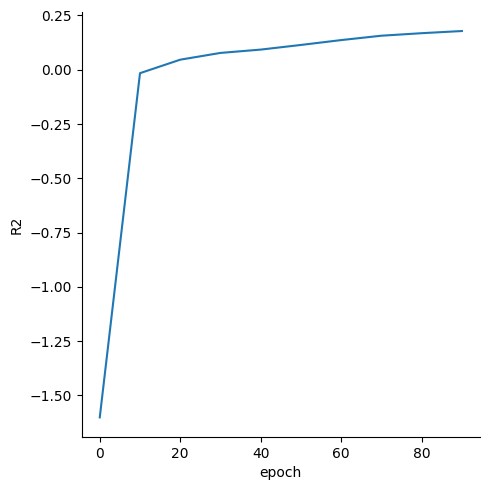

In [135]:
sns.relplot(data = {"epoch": list(check_losses.keys()), "R2": [1 - loss for loss in check_losses.values()]},
           x = "epoch", y = "R2", kind = "line")
plt.show()